# Creating a frequency finder auto-encoder

## Import Libraries

In [336]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plttest
from tensorflow.keras import callbacks
import tensorflow.keras as keras
from tensorflow.keras import layers
import umap
from babyplots import Babyplot
#import hdbscan
from matplotlib import pyplot
from models import *
from converters import *
from helpers import *
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [337]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data from drive

In [3]:
try:
    drive_path = find_drive_path()
    data = pd.read_pickle(f"{drive_path}/Data/Inputs/Synthetisch/Syn_tot.pkl")
except:
    data = pd.read_pickle("../../Data/Syn01_02.pkl")
data.head()

,IID,Pheno,Geno,State
0,0pop1,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy
1,1pop1,1,"[0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick
2,2pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick
3,3pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, ...",pop1sick
4,4pop1,1,"[2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, ...",pop1sick


In [4]:
data.tail()

,IID,Pheno,Geno,State
1995,995pop2,1,"[0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, ...",pop2sick
1996,996pop2,0,"[1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, ...",pop2healthy
1997,997pop2,0,"[0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, ...",pop2healthy
1998,998pop2,0,"[2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, ...",pop2healthy
1999,999pop2,0,"[0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1, 0, ...",pop2healthy


## Preprocessing data into tensors 

### Keeping only the minor alleles as 1

In [5]:
X = only_minor(data["Geno"])
y = data["Pheno"]
y

0       0
1       1
2       1
3       1
4       1
       ..
1995    1
1996    0
1997    0
1998    0
1999    0
Name: Pheno, Length: 2000, dtype: int64

### Train test split

In [6]:
split = splitter([X,y],0.1)
[X_train, X_test, y_train, y_test] = tensor_converter(split)
X = tensor_converter(X)
y = tensor_converter(y)
X = tf.stack(X, axis = 0)
y = tf.stack(y, axis = 0)

2021-10-07 09:26:20.894844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 09:26:20.895152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-07 09:26:20.895214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-07 09:26:20.895259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-07 09:26:20.911771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## Model 1

### Loading hyper-parameters

In [7]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 46

### Building the model

In [8]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

### Training the model with a bottleneck of 46

In [9]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 150,
          callbacks=[es,cp_callback],
          verbose = 1)

2021-10-07 09:26:21.551177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150








55/57 [===========================>..] - ETA: 0s - loss: 6.1432 - binary_accuracy: 0.5914



57/57 [==============================] - 2s 28ms/step - loss: 6.1421 - binary_accuracy: 0.5916 - val_loss: 6.0779 - val_binary_accuracy: 0.6031
Epoch 2/150
57/57 [==============================] - 1s 25ms/step - loss: 6.0016 - binary_accuracy: 0.6080 - val_loss: 6.0038 - val_binary_accuracy: 0.6080
Epoch 3/150
57/57 [==============================] - 1s 25ms/step - loss: 5.9848 - binary_accuracy: 0.6093 - val_loss: 5.9933 - val_binary_accuracy: 0.6087
Epoch 4/150
57/57 [==============================] - 2s 27ms/step - loss: 5.9831 - binary_accuracy: 0.6094 - val_loss: 5.9887 - val_binary_accuracy: 0.6090
Epoch 5/150
57/57 [==============================] - 1s 26ms/step - loss: 5.9772 - binary_accuracy: 0.6098 - val_loss: 5.9861 - val_binary_accuracy: 0.6092
Epoch 6/150
35/57 [=================>............] - ETA: 0s - loss: 5.9742 - binary_accuracy: 0.6099
Epoch 00006: savi

### Plotting metrics

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

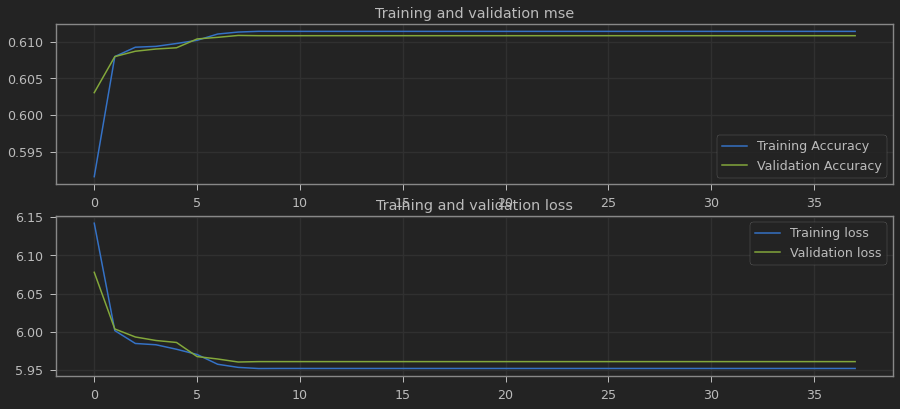

In [10]:
metrics_viewer(autoencoder_model)

### Extracting values of bottleneck

In [11]:
hidden_repr = AE.layers[0](X)

### Visualization in 3D

In [12]:
reducer = umap.UMAP(random_state = 42)
reducer.fit(hidden_repr)
embedding = reducer.transform(hidden_repr)
reducer3d = umap.UMAP(random_state = 42, n_components = 3)
reducer3d.fit(hidden_repr)
embedding3d = reducer3d.transform(hidden_repr)

In [13]:
labels = color_label_maker(hidden_repr,2)

In [14]:
bp = Babyplot()
#"customColorScale": "Dark2", "Paired", "Viridis", "Set2"
bp.add_plot(embedding3d.tolist(), "pointCloud",
           "categories", labels, {
               "size": 1.5,
               "colorScale":"custom",
               "customColorScale": "Paired",
               "folded": True,
               "showLegend": True,
               "legendTitle": "Population",
               "legendTitleFontSize": 20,
               "legendTitleFontColor":"#93c273",
               "fontColor": "#60AFEF",
               "fontSize": 15,
               "foldedEmbedding": embedding.tolist(),
           })
bp.background_color = "#2b5480"
#bp.show_ui = True
bp

<IPython.core.display.Javascript object>

## Model 2

### Loading hyper

In [15]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 1

### Building model

In [16]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

### Training model with bottleneck of 1

In [17]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=100, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 250,
          callbacks=[es,cp_callback],
          verbose = 1)

Epoch 1/250








56/57 [============================>.] - ETA: 0s - loss: 7.7832 - binary_accuracy: 0.4841



57/57 [==============================] - 2s 28ms/step - loss: 7.7851 - binary_accuracy: 0.4840 - val_loss: 8.1421 - val_binary_accuracy: 0.4670
Epoch 2/250
57/57 [==============================] - 1s 25ms/step - loss: 8.0925 - binary_accuracy: 0.4699 - val_loss: 7.2489 - val_binary_accuracy: 0.5237
Epoch 3/250
57/57 [==============================] - 1s 25ms/step - loss: 6.6276 - binary_accuracy: 0.5652 - val_loss: 6.3043 - val_binary_accuracy: 0.5829
Epoch 4/250
57/57 [==============================] - 1s 25ms/step - loss: 5.2518 - binary_accuracy: 0.6563 - val_loss: 5.1098 - val_binary_accuracy: 0.6669
Epoch 5/250
57/57 [==============================] - 1s 26ms/step - loss: 5.0371 - binary_accuracy: 0.6716 - val_loss: 4.9754 - val_binary_accuracy: 0.6758
Epoch 6/250
35/57 [=================>............] - ETA: 0s - loss: 4.9557 - binary_accuracy: 0.6771
Epoch 00006: savi

57/57 [==============================] - 2s 28ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 46/250
57/57 [==============================] - 1s 26ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 47/250
57/57 [==============================] - 1s 25ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 48/250
57/57 [==============================] - 1s 25ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 49/250
57/57 [==============================] - 1s 24ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 50/250
57/57 [==============================] - 1s 25ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 51/250
28/57 [=============>................] - ETA: 0s - loss: 4

57/57 [==============================] - 2s 28ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 91/250
57/57 [==============================] - 2s 27ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 92/250
57/57 [==============================] - 1s 26ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 93/250
57/57 [==============================] - 1s 25ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 94/250
57/57 [==============================] - 1s 25ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 95/250
57/57 [==============================] - 1s 25ms/step - loss: 4.7376 - binary_accuracy: 0.6915 - val_loss: 4.7357 - val_binary_accuracy: 0.6917
Epoch 96/250
25/57 [============>.................] - ETA: 0s - loss: 4

### Plotting metrics

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

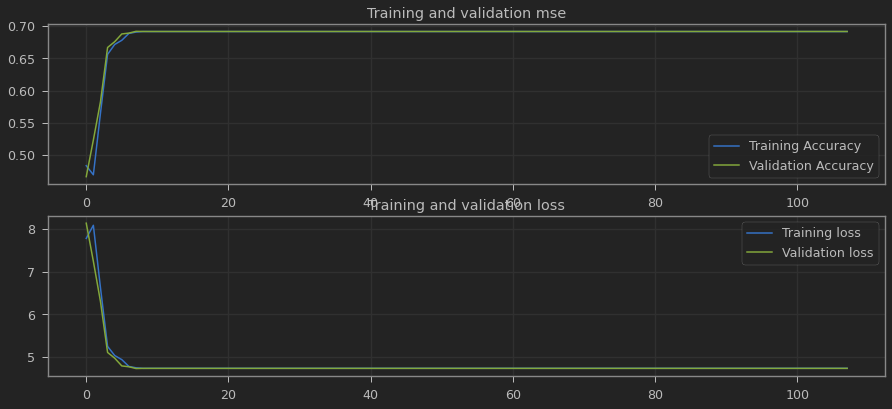

In [18]:
metrics_viewer(autoencoder_model)

### Extracting values of bottleneck

In [19]:
hidden_repr = AE.layers[0](X)

In [20]:
x = np.array(hidden_repr)

In [21]:
x1 = x[0:int(len(x)/2)]
x2 = x[int(len(x)/2):]

In [22]:
x1[:,0]

array([-498.3562 , -451.2479 , -492.91245, -501.2769 , -480.54   ,
       -483.3123 , -514.2026 , -511.94052, -470.79315, -497.13712,
       -518.9211 , -481.51663, -492.08408, -497.27042, -483.1169 ,
       -512.9952 , -479.71503, -478.81192, -506.605  , -521.98737,
       -468.93866, -478.35464, -493.8274 , -511.0944 , -527.36456,
       -486.56665, -480.04297, -521.28424, -469.35687, -493.28052,
       -485.81595, -497.6916 , -494.98715, -446.7342 , -503.2334 ,
       -489.51694, -487.18494, -505.33228, -443.71634, -526.5843 ,
       -482.11957, -474.51645, -491.15564, -482.9314 , -530.09247,
       -514.2339 , -496.48953, -523.8683 , -517.4351 , -468.07986,
       -494.23828, -506.09268, -477.88962, -487.97293, -491.95013,
       -493.6335 , -487.33737, -471.16122, -487.3999 , -504.33   ,
       -461.69583, -528.973  , -503.52786, -509.83197, -467.3389 ,
       -467.05124, -533.7055 , -497.3619 , -504.41672, -492.47333,
       -466.2632 , -486.02643, -483.94412, -479.2748 , -512.18

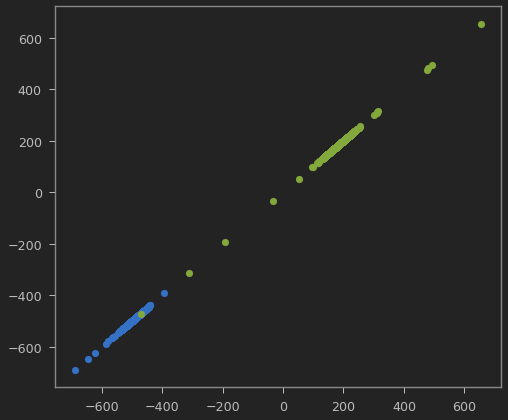

In [23]:
try:
    plt.scatter(x1[:,0], x1[:,1])
    plt.scatter(x2[:,0], x2[:,1])
    plt.show
except:
    plt.scatter(x1, x1)
    plt.scatter(x2, x2)

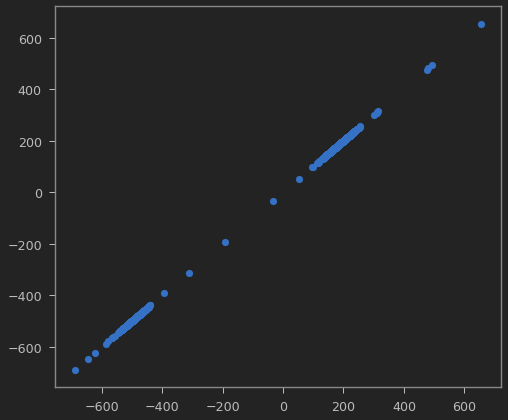

In [24]:
plt.scatter(x, x)

In [25]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(x)
 
print(label)

[0 0 0 ... 1 1 1]


In [26]:
abs(x)

array([[498.3562 ],
       [451.2479 ],
       [492.91245],
       ...,
       [183.23952],
       [174.23776],
       [249.8375 ]], dtype=float32)

In [27]:
data["first_component"] = x

In [28]:
data

,IID,Pheno,Geno,State,first_component
0,0pop1,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy,-498.356201
1,1pop1,1,"[0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick,-451.247894
2,2pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick,-492.912445
3,3pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, ...",pop1sick,-501.276886
4,4pop1,1,"[2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, ...",pop1sick,-480.540009
...,...,...,...,...,...
1995,995pop2,1,"[0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, ...",pop2sick,219.875381
1996,996pop2,0,"[1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, ...",pop2healthy,133.403549
1997,997pop2,0,"[0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, ...",pop2healthy,183.239517
1998,998pop2,0,"[2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, ...",pop2healthy,174.237762


In [29]:
data_sorted = data.sort_values(by=['first_component'])
data_sorted

,IID,Pheno,Geno,State,first_component
723,723pop1,1,"[2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, ...",pop1sick,-688.500183
799,799pop1,1,"[2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick,-646.946106
653,653pop1,1,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick,-623.387878
860,860pop1,0,"[0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, ...",pop1healthy,-587.848999
266,266pop1,1,"[2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, ...",pop1sick,-578.933533
...,...,...,...,...,...
1607,607pop2,0,"[1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, ...",pop2healthy,315.214264
1504,504pop2,1,"[2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 1, ...",pop2sick,475.870850
1564,564pop2,1,"[0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, ...",pop2sick,480.857330
1578,578pop2,1,"[1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 1, ...",pop2sick,492.494019


In [264]:
test = np.array(data_sorted['Geno'].to_list())[:,0] - 1

In [300]:
genos = np.array(data_sorted['Geno'].to_list())
len(genos[0])

10000

In [301]:
genos[:,0] - 1

array([ 1,  1,  1, ..., -1,  0,  0])

In [265]:
major = np.where(test == -1, 0, test)
minor = np.where(test == 1, 0, test)
major

array([1, 1, 1, ..., 0, 0, 0])

In [266]:
minor

array([ 0,  0,  0, ..., -1,  0,  0])

In [267]:
test

array([ 1,  1,  1, ..., -1,  0,  0])

In [297]:
x_axis = np.array(range(0, len(minor), 1))
x_axis

array([   0,    1,    2, ..., 1997, 1998, 1999])

<function matplotlib.pyplot.show(close=None, block=None)>

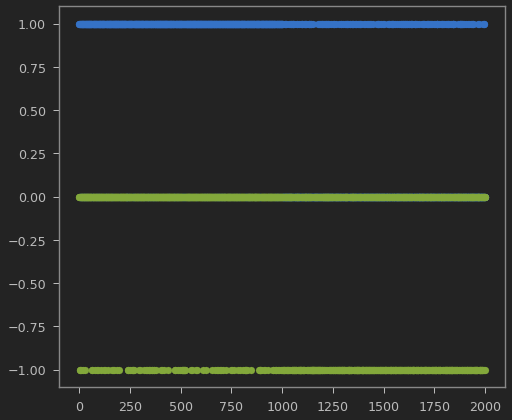

In [269]:
plt.scatter(x_axis, major)
plt.scatter(x_axis, minor)
plt.show

In [270]:
test

array([ 1,  1,  1, ..., -1,  0,  0])

In [271]:
nr_splits = 50

In [272]:
arrays = np.split(test, nr_splits)


In [273]:
array_sums = []
for array in arrays:
    array_sums.append(sum(array)/len(array))
array_sums

[0.6,
 0.75,
 0.675,
 0.725,
 0.725,
 0.75,
 0.6,
 0.725,
 0.575,
 0.7,
 0.725,
 0.75,
 0.55,
 0.725,
 0.875,
 0.775,
 0.775,
 0.6,
 0.775,
 0.725,
 0.6,
 0.8,
 0.625,
 0.775,
 0.575,
 -0.175,
 -0.125,
 -0.15,
 -0.325,
 -0.3,
 -0.075,
 -0.225,
 -0.3,
 -0.225,
 -0.4,
 -0.25,
 -0.25,
 -0.375,
 -0.25,
 -0.25,
 -0.125,
 -0.325,
 -0.225,
 -0.275,
 -0.05,
 -0.4,
 -0.1,
 -0.175,
 -0.325,
 -0.225]

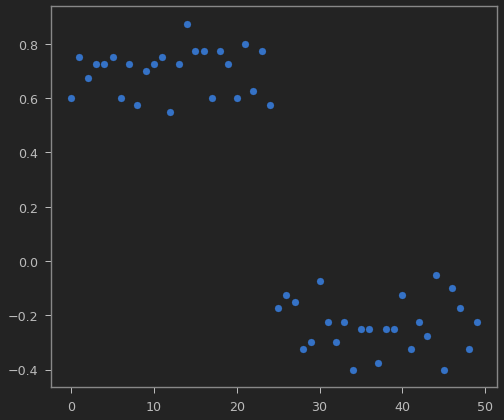

In [274]:
plt.scatter(x_axis[0:nr_splits], array_sums)

In [275]:
p = list(map(lambda x:(x+1)/2, array_sums))
p

[0.8,
 0.875,
 0.8375,
 0.8625,
 0.8625,
 0.875,
 0.8,
 0.8625,
 0.7875,
 0.85,
 0.8625,
 0.875,
 0.775,
 0.8625,
 0.9375,
 0.8875,
 0.8875,
 0.8,
 0.8875,
 0.8625,
 0.8,
 0.9,
 0.8125,
 0.8875,
 0.7875,
 0.4125,
 0.4375,
 0.425,
 0.3375,
 0.35,
 0.4625,
 0.3875,
 0.35,
 0.3875,
 0.3,
 0.375,
 0.375,
 0.3125,
 0.375,
 0.375,
 0.4375,
 0.3375,
 0.3875,
 0.3625,
 0.475,
 0.3,
 0.45,
 0.4125,
 0.3375,
 0.3875]

In [276]:
# 1*q + -1*(1-q) = 
q = list(map(lambda x:1-((x+1)/2), array_sums))
q

[0.19999999999999996,
 0.125,
 0.16249999999999998,
 0.13749999999999996,
 0.13749999999999996,
 0.125,
 0.19999999999999996,
 0.13749999999999996,
 0.21250000000000002,
 0.15000000000000002,
 0.13749999999999996,
 0.125,
 0.22499999999999998,
 0.13749999999999996,
 0.0625,
 0.11250000000000004,
 0.11250000000000004,
 0.19999999999999996,
 0.11250000000000004,
 0.13749999999999996,
 0.19999999999999996,
 0.09999999999999998,
 0.1875,
 0.11250000000000004,
 0.21250000000000002,
 0.5875,
 0.5625,
 0.575,
 0.6625,
 0.65,
 0.5375,
 0.6125,
 0.65,
 0.6125,
 0.7,
 0.625,
 0.625,
 0.6875,
 0.625,
 0.625,
 0.5625,
 0.6625,
 0.6125,
 0.6375,
 0.525,
 0.7,
 0.55,
 0.5875,
 0.6625,
 0.6125]

In [277]:
x_reduced = x_axis[0:nr_splits]*(x_axis[-1]/nr_splits)

<function matplotlib.pyplot.show(close=None, block=None)>

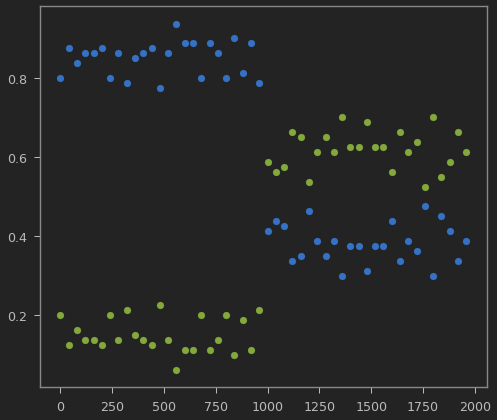

In [278]:
plt.scatter(x_reduced, p)
plt.scatter(x_reduced, q)
plt.show

In [288]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'elu'))
model.add(keras.layers.Dense(units = 64, activation = 'elu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 4,355
Trainable params: 4,355
Non-trainable params: 0
_________________________________________________________________


In [293]:
model.fit( x_reduced, np.array(p), epochs=1000, verbose=1)

Epoch 1/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0615
Epoch 2/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 3/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch 4/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0696
Epoch 5/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0683
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 7/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0483
Epoch 8/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 9/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0389
Epoch 10/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0410
Epoch 11/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 12/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0327
Epoch 13/1000
2/2 [==============================

2/2 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 104/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 105/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 106/1000
2/2 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 107/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 108/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 109/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 110/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 111/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 112/1000
2/2 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 113/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 114/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 115/1000
2/2 [===================

2/2 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 204/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 205/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 206/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 207/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 208/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 209/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 210/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 211/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 212/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 213/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 214/1000
2/2 [==============================] - 0s 981us/step - loss: 0.0083
Epoch 215/1000
2/2 [=====================

2/2 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 304/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 305/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 306/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 307/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 308/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 309/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 310/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 311/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 312/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 313/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 314/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 315/1000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 405/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 406/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 407/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 408/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 409/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 410/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 411/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 412/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 413/1000
2/2 [==============================] - 0s 976us/step - loss: 0.0076
Epoch 414/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 415/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 416/1000
2/2 [=====================

2/2 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 505/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 506/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 507/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 508/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 509/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 510/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 511/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 512/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 513/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 514/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 515/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 516/1000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 606/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 607/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 608/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 609/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 610/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 611/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 612/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 613/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 614/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 615/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 616/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 617/1000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 707/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 708/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 709/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 710/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 711/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 712/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 713/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 714/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 715/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 716/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 717/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 718/1000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 808/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 809/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 810/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 811/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 812/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 813/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 814/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 815/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 816/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 817/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 818/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 819/1000
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 909/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 910/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 911/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 912/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 913/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 914/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 915/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 916/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 917/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 918/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 919/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 920/1000
2/2 [=======================

In [315]:
model.save("../../Data/MyPoliFitModel")

2021-10-07 12:14:36.533110: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../Data/MyPoliFitModel/assets


In [294]:
y_predicted = model.predict(x_axis)

In [295]:
y_predicted

array([[0.7975381 ],
       [0.80395657],
       [0.80986834],
       ...,
       [0.41483167],
       [0.41505602],
       [0.4152718 ]], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

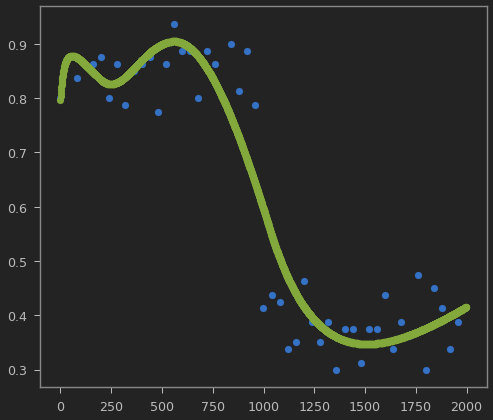

In [296]:
plt.scatter(x_reduced, p)
plt.scatter(x_axis, y_predicted)
plt.show

In [287]:
len(y_predicted)

2000

In [321]:
nr_splits = 50
genos = np.array(data_sorted['Geno'].to_list())
p_matrix = p_finder(genos, nr_splits)
x_axis = np.array(range(0, len(genos), 1))
x_reduced = x_axis[0:nr_splits]*(x_axis[-1]/nr_splits)

In [341]:
q_pred_mat = polifit_model(x_reduced, p_matrix, x_axis)

In [350]:
temp = np.array(q_pred_mat).T

In [360]:
listy = temp.tolist()

In [364]:
data_sorted['p_array'] = listy[0]

In [365]:
data_sorted

,IID,Pheno,Geno,State,first_component,p_array
723,723pop1,1,"[2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, ...",pop1sick,-688.500183,"[0.8001267313957214, 0.8257184624671936, 0.837..."
799,799pop1,1,"[2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick,-646.946106,"[0.8399625420570374, 0.8677695393562317, 0.878..."
653,653pop1,1,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick,-623.387878,"[0.8686140179634094, 0.8985975384712219, 0.909..."
860,860pop1,0,"[0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, ...",pop1healthy,-587.848999,"[0.8888921737670898, 0.9208025336265564, 0.930..."
266,266pop1,1,"[2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, ...",pop1sick,-578.933533,"[0.9037206768989563, 0.9372332692146301, 0.946..."
...,...,...,...,...,...,...
1607,607pop2,0,"[1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, ...",pop2healthy,315.214264,"[0.21545056998729706, 0.3460789620876312, 0.31..."
1504,504pop2,1,"[2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 1, ...",pop2sick,475.870850,"[0.21511296927928925, 0.3458004891872406, 0.31..."
1564,564pop2,1,"[0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, ...",pop2sick,480.857330,"[0.21474675834178925, 0.34550294280052185, 0.3..."
1578,578pop2,1,"[1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 1, ...",pop2sick,492.494019,"[0.21437101066112518, 0.3452225625514984, 0.31..."
